# Paso 1: Instalación de dependencias

In [19]:
# 1️⃣ Instalación de dependencias
# Este paso asegura que tengamos todas las librerías necesarias instaladas en nuestro entorno de Google Colab.
# `!pip install` se usa para instalar paquetes de Python.
# `tensorflow`: Una librería de código abierto para aprendizaje automático.
# `tensorflow-hub`: Una librería que permite reutilizar modelos de machine learning pre-entrenados, como YAMNet.
# `librosa`: Una librería para análisis de audio y música.
# `numpy`: Una librería fundamental para computación numérica con Python, especialmente para trabajar con arrays.
# `matplotlib`: Una librería para crear visualizaciones estáticas e interactivas en Python.
# `scikit-learn`: Una librería para machine learning que incluye herramientas para clasificación, regresión, clustering, etc.
# `pandas`: Una librería para manipulación y análisis de datos, especialmente útil con estructuras como DataFrames.

# Paso 2: Importaciones y configuración

In [20]:
# 2️⃣ Importar librerías necesarias
# Aquí importamos todas las librerías que usaremos a lo largo del cuaderno.
# Cada `import` trae un módulo o una función específica que nos ayudará con diferentes tareas.
import tensorflow as tf # Para construir y ejecutar modelos de aprendizaje automático.
import tensorflow_hub as hub # Para cargar modelos pre-entrenados, como YAMNet.
import librosa # Para cargar y procesar archivos de audio.
import numpy as np # Para realizar operaciones numéricas eficientes, especialmente con arreglos.
import matplotlib.pyplot as plt # Para crear gráficos y visualizar datos.
import pandas as pd # Para manejar y analizar datos en formato de tabla (DataFrames).
from sklearn.model_selection import train_test_split, cross_val_score # `train_test_split` para dividir los datos en conjuntos de entrenamiento y prueba, `cross_val_score` para validación cruzada.
from sklearn.ensemble import RandomForestClassifier # Aunque no se usa en el ejemplo actual, es un tipo de clasificador de machine learning.
from sklearn.svm import SVC # Support Vector Classifier, un algoritmo de clasificación que usaremos.
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # Para evaluar el rendimiento de nuestro modelo.
import os # Para interactuar con el sistema operativo, como trabajar con rutas de archivos.
import glob # Para encontrar archivos y rutas que coincidan con un patrón específico (ej. *.wav).

# Configuración de visualización
plt.style.use('seaborn-v0_8') # Esta línea aplica un estilo visual predefinido a los gráficos de Matplotlib, haciéndolos más atractivos.
print("✅ Librerías importadas correctamente.") # Mensaje para confirmar que todas las librerías se cargaron sin problemas.

✅ Librerías importadas correctamente.


# Paso 3: Carga y preprocesamiento del dataset

In [21]:
# 3️⃣ Carga y preprocesamiento del dataset
print("Cargando modelo YAMNet...") # Mensaje informativo sobre la carga del modelo.
# Cargar modelo YAMNet desde TensorFlow Hub. YAMNet es un modelo de audio pre-entrenado que puede clasificar eventos de sonido.
# Nos devolverá 'embeddings' (representaciones numéricas) del audio, que son útiles para el entrenamiento de nuestro propio clasificador.
model = hub.load('https://tfhub.dev/google/yamnet/1')

# Montar Google Drive
# Esto permite que nuestro cuaderno de Colab acceda a los archivos almacenados en tu Google Drive.
from google.colab import drive # Importa la función para montar Drive.
drive.mount('/content/drive') # Ejecuta el montaje de Google Drive. Tendrás que autorizarlo.

# Definir rutas a tus carpetas de audio
# Es crucial que estas rutas apunten a donde tienes tus archivos de audio 'fuego' y 'no_fuego'.
ruta_datos = "/content/drive/MyDrive/2. Investigación y SNI/Proyectos de investigación/devCode Challenge 2025/Code/dataset" # Ajusta esta ruta si es necesario.
ruta_fuego = os.path.join(ruta_datos, "fuego") # Ruta a la carpeta con audios de fuego.
ruta_no_fuego = os.path.join(ruta_datos, "no_fuego") # Ruta a la carpeta con audios que no son fuego.

# Función para extraer embeddings de YAMNet
# Esta función toma un archivo de audio, lo procesa con YAMNet y devuelve un 'embedding'.
def extract_embedding(audio_path, model):
    try:
        # Cargar audio usando librosa. Lo resamplea a 16000 Hz (frecuencia de muestreo estándar para YAMNet) y lo convierte a mono (un solo canal).
        waveform, sr = librosa.load(audio_path, sr=16000, mono=True)
        # Realiza la inferencia con el modelo YAMNet. Esto nos da 'scores' (puntuaciones de clase), 'embeddings' (representaciones vectoriales del audio) y 'spectrogram' (representación visual de las frecuencias de audio).
        scores, embeddings, spectrogram = model(waveform)
        # Tomamos el promedio de los embeddings a lo largo del tiempo. Un embedding es un vector numérico que representa las características del audio.
        embedding_mean = np.mean(embeddings, axis=0)
        return embedding_mean # Devuelve el embedding promedio.
    except Exception as e:
        print(f"Error procesando {audio_path}: {e}") # Si ocurre un error al procesar un archivo, lo imprime.
        return None # Devuelve None si hay un error.

# Cargar y procesar audios de la clase "fuego"
embeddings_fuego = [] # Lista para almacenar los embeddings de audios de fuego.
audios_fuego = glob.glob(os.path.join(ruta_fuego, "*.wav"))[:100] # Encuentra todos los archivos .wav en la carpeta 'fuego' y toma los primeros 100.
print(f"Procesando {len(audios_fuego)} audios de 'fuego'...") # Mensaje informativo.
for audio_path in audios_fuego: # Itera sobre cada ruta de archivo de fuego.
    emb = extract_embedding(audio_path, model) # Extrae el embedding.
    if emb is not None: # Si el embedding se extrajo correctamente (no hubo error).
        embeddings_fuego.append(emb) # Lo añade a la lista.
    else:
        print(f"  - Ignorado: {audio_path}") # Si hubo un error, se ignora el archivo.

# Cargar y procesar audios de la clase "no_fuego"
embeddings_no_fuego = [] # Lista para almacenar los embeddings de audios que no son fuego.
audios_no_fuego = glob.glob(os.path.join(ruta_no_fuego, "*.wav"))[:100] # Encuentra todos los archivos .wav en la carpeta 'no_fuego' y toma los primeros 100.
print(f"Procesando {len(audios_no_fuego)} audios de 'no_fuego'...") # Mensaje informativo.
for audio_path in audios_no_fuego: # Itera sobre cada ruta de archivo de no_fuego.
    emb = extract_embedding(audio_path, model) # Extrae el embedding.
    if emb is not None: # Si el embedding se extrajo correctamente.
        embeddings_no_fuego.append(emb) # Lo añade a la lista.
    else:
        print(f"  - Ignorado: {audio_path}") # Si hubo un error, se ignora el archivo.

print("\n✅ Extracción de embeddings completada.") # Mensaje de confirmación.

# Crear etiquetas (1 para fuego, 0 para no_fuego)
labels_fuego = [1] * len(embeddings_fuego) # Crea una lista de '1's, una por cada audio de fuego.
labels_no_fuego = [0] * len(embeddings_no_fuego) # Crea una lista de '0's, una por cada audio de no_fuego.

# Combinar datos y etiquetas
# `X` serán nuestras características (los embeddings de audio).
# `y` serán nuestras etiquetas (1 para fuego, 0 para no_fuego).
X = np.array(embeddings_fuego + embeddings_no_fuego) # Concatena las listas de embeddings y las convierte en un arreglo NumPy.
y = np.array(labels_fuego + labels_no_fuego) # Concatena las listas de etiquetas y las convierte en un arreglo NumPy.

print(f"\nDataset final: {X.shape[0]} muestras, {X.shape[1]} características (embeddings de YAMNet), {len(embeddings_fuego)} fuego, {len(embeddings_no_fuego)} no_fuego.") # Imprime un resumen del dataset creado.

Cargando modelo YAMNet...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Procesando 100 audios de 'fuego'...
Procesando 100 audios de 'no_fuego'...

✅ Extracción de embeddings completada.

Dataset final: 200 muestras, 1024 características (embeddings de YAMNet), 100 fuego, 100 no_fuego.


# Paso 4: División del dataset

In [22]:
# 4️⃣ División del dataset en entrenamiento, validación y prueba
# Es fundamental dividir el dataset para entrenar el modelo, ajustar sus parámetros y finalmente evaluar su rendimiento con datos que nunca ha visto.
# `train_test_split` es una función de scikit-learn para dividir los datos.
# `test_size=0.2`: 20% de los datos se usarán para el conjunto de prueba final.
# `random_state=42`: Asegura que la división de datos sea la misma cada vez que se ejecuta el código (reproducibilidad).
# `stratify=y`: Mantiene la misma proporción de clases (fuego/no_fuego) en cada conjunto (entrenamiento y prueba), útil cuando las clases están desbalanceadas.

# Primero, separar en entrenamiento+validación (80%) y prueba (20%)
# `X_temp` e `y_temp` contendrán los datos para entrenamiento y validación.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Luego, separar la parte de entrenamiento+validación en entrenamiento (70% del total) y validación (10% del total)
# El 70% del total es el 87.5% de (entrenamiento+validación), y el 10% del total es el 12.5% de (entrenamiento+validación)
# `test_size=0.125`: Significa que el 12.5% de `X_temp` e `y_temp` (que era el 80% del total) se usará para validación.
# 0.125 * 0.80 = 0.10 (10% del total) para validación.
# 0.875 * 0.80 = 0.70 (70% del total) para entrenamiento.
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

# Imprimir el tamaño de cada conjunto para verificar que la división fue correcta.
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras") # Datos para entrenar el modelo.
print(f"Conjunto de validación: {X_val.shape[0]} muestras") # Datos para ajustar hiperparámetros del modelo y evaluar durante el desarrollo.
print(f"Conjunto de prueba: {X_test.shape[0]} muestras") # Datos 'nuevos' para una evaluación final y objetiva del modelo.

Conjunto de entrenamiento: 140 muestras
Conjunto de validación: 20 muestras
Conjunto de prueba: 40 muestras


In [23]:
# Paso 5: Entrenamiento del modelo (Ejemplo con SVM)

In [24]:
# 5️⃣ Entrenamiento del modelo
# Aquí entrenamos nuestro clasificador usando el conjunto de datos de entrenamiento.
# Usamos un clasificador SVM (Support Vector Machine) como ejemplo. Es un algoritmo potente para tareas de clasificación.
print("Entrenando modelo SVM...") # Mensaje informativo.
# `SVC`: Es la clase para el clasificador de vectores de soporte.
# `kernel='rbf'`: Define la función del kernel. 'rbf' (Radial Basis Function) es un kernel común y efectivo para datos no lineales.
# `probability=True`: Permite al modelo estimar probabilidades de clase, lo cual es útil para ciertas métricas de evaluación o si queremos saber qué tan seguro está el modelo de su predicción.
# `random_state=42`: Para asegurar la reproducibilidad del entrenamiento del modelo.
model_clf = SVC(kernel='rbf', probability=True, random_state=42)
# `model_clf.fit(X_train, y_train)`: Este es el paso donde el modelo 'aprende' de los datos de entrenamiento.
# `X_train` son las características (embeddings) y `y_train` son las etiquetas (fuego/no_fuego).
model_clf.fit(X_train, y_train)
print("✅ Modelo entrenado.") # Mensaje de confirmación del entrenamiento.

Entrenando modelo SVM...
✅ Modelo entrenado.


# Paso 6: Evaluación en el conjunto de validación

Evaluando en el conjunto de validación...
Precisión en Validación: 1.0000

Reporte de Clasificación (Validación):
              precision    recall  f1-score   support

    No Fuego       1.00      1.00      1.00        10
       Fuego       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



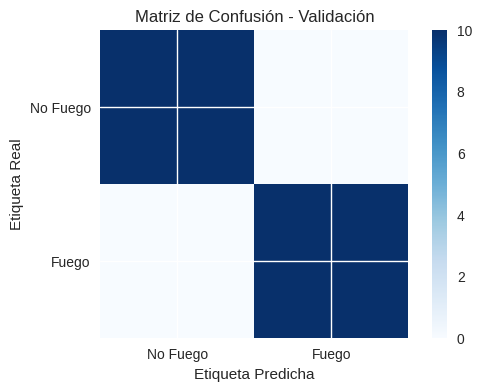

In [25]:
# 6️⃣ Evaluación en el conjunto de validación
# Después de entrenar el modelo, evaluamos su rendimiento en el conjunto de validación.
# Esto nos ayuda a entender qué tan bien se generaliza el modelo a datos no vistos durante el entrenamiento.
print("Evaluando en el conjunto de validación...") # Mensaje informativo.
# `model_clf.predict(X_val)`: El modelo hace predicciones sobre las características del conjunto de validación (`X_val`).
y_val_pred = model_clf.predict(X_val)
# `accuracy_score`: Calcula la precisión, que es la proporción de predicciones correctas.
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Precisión en Validación: {val_accuracy:.4f}\n") # Imprime la precisión del modelo en el conjunto de validación.
print("Reporte de Clasificación (Validación):") # Encabezado para el reporte.
# `classification_report`: Genera un informe detallado que incluye precisión, recall, f1-score y soporte para cada clase.
# `target_names`: Asigna nombres legibles a las clases (0 y 1).
print(classification_report(y_val, y_val_pred, target_names=['No Fuego', 'Fuego']))

# Matriz de confusión en validación
# La matriz de confusión nos muestra cuántas predicciones fueron correctas e incorrectas para cada clase.
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4)) # Define el tamaño de la figura para el gráfico.
plt.title("Matriz de Confusión - Validación") # Título del gráfico.
plt.imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues) # Muestra la matriz como una imagen con un mapa de color azul.
plt.colorbar() # Añade una barra de color para interpretar los valores.
tick_marks = np.arange(2) # Define las posiciones de las etiquetas de los ejes.
plt.xticks(tick_marks, ['No Fuego', 'Fuego']) # Establece las etiquetas para el eje X (predicciones).
plt.yticks(tick_marks, ['No Fuego', 'Fuego']) # Establece las etiquetas para el eje Y (valores reales).
plt.ylabel('Etiqueta Real') # Etiqueta del eje Y.
plt.xlabel('Etiqueta Predicha') # Etiqueta del eje X.
plt.show() # Muestra el gráfico.

# Paso 7: Evaluación final en el conjunto de prueba

Evaluando en el conjunto de prueba (reservado)...
Precisión en Prueba: 1.0000

Reporte de Clasificación (Prueba):
              precision    recall  f1-score   support

    No Fuego       1.00      1.00      1.00        20
       Fuego       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



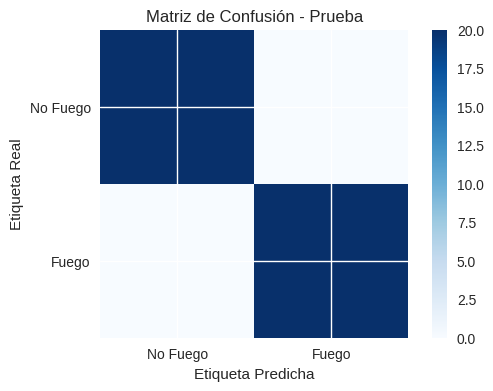


✅ Evaluación final completada.


In [26]:
# 7️⃣ Evaluación final en el conjunto de prueba
# Esta es la evaluación más importante, ya que se realiza con datos completamente nuevos que el modelo no ha visto en ninguna etapa de entrenamiento o validación.
# Nos da una estimación realista del rendimiento del modelo en el mundo real.
print("Evaluando en el conjunto de prueba (reservado)...") # Mensaje informativo.
# `model_clf.predict(X_test)`: El modelo hace predicciones sobre las características del conjunto de prueba (`X_test`).
y_test_pred = model_clf.predict(X_test)
# `accuracy_score`: Calcula la precisión del modelo en el conjunto de prueba.
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Precisión en Prueba: {test_accuracy:.4f}\n") # Imprime la precisión del modelo en el conjunto de prueba.
print("Reporte de Clasificación (Prueba):") # Encabezado para el reporte.
# `classification_report`: Genera un informe detallado con métricas para cada clase en el conjunto de prueba.
print(classification_report(y_test, y_test_pred, target_names=['No Fuego', 'Fuego']))

# Matriz de confusión en prueba
# Visualiza la matriz de confusión para entender las predicciones correctas e incorrectas en el conjunto de prueba.
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4)) # Define el tamaño de la figura.
plt.title("Matriz de Confusión - Prueba") # Título del gráfico.
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues) # Muestra la matriz.
plt.colorbar() # Añade barra de color.
tick_marks = np.arange(2) # Define las posiciones de las etiquetas.
plt.xticks(tick_marks, ['No Fuego', 'Fuego']) # Etiquetas eje X.
plt.yticks(tick_marks, ['No Fuego', 'Fuego']) # Etiquetas eje Y.
plt.ylabel('Etiqueta Real') # Etiqueta del eje Y.
plt.xlabel('Etiqueta Predicha') # Etiqueta del eje X.
plt.show() # Muestra el gráfico.

print("\n✅ Evaluación final completada.") # Mensaje de confirmación de la evaluación final.

# Paso 8 : Validación Cruzada

In [27]:
# 8️⃣ Validación cruzada (Opcional, para una estimación más robusta)
# La validación cruzada es una técnica que evalúa el rendimiento del modelo dividiendo los datos de entrenamiento en múltiples subconjuntos (folds).
# El modelo se entrena y valida varias veces, cada vez con un fold diferente como validación y el resto como entrenamiento.
# Esto proporciona una estimación más robusta y menos sesgada del rendimiento del modelo en comparación con una sola división entrenamiento/validación.
print("Realizando validación cruzada (5-Fold)...") # Mensaje informativo.
# Creamos una nueva instancia del clasificador SVC para la validación cruzada.
clf_cv = SVC(kernel='rbf', random_state=42)
# `cross_val_score`: Realiza la validación cruzada.
# `cv=5`: Indica que se usarán 5 'folds' (subdivisiones) de los datos.
# `scoring='accuracy'`: La métrica de evaluación que se usará para cada fold es la precisión.
cv_scores = cross_val_score(clf_cv, X_train, y_train, cv=5, scoring='accuracy')
# Imprime la precisión obtenida en cada uno de los 5 folds.
print(f"Puntajes de validación cruzada: {cv_scores}")
# Calcula y imprime la media de las precisiones de los folds, junto con su desviación estándar (que indica la variabilidad de los resultados).
print(f"Media de la precisión (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Realizando validación cruzada (5-Fold)...
Puntajes de validación cruzada: [1. 1. 1. 1. 1.]
Media de la precisión (CV): 1.0000 (+/- 0.0000)
